In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-13 12:40:11.305642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load Koch Meinhardt dataset

- $D_a = 0.005, \quad D_s=0.2$.
- $\mu_a = 0.01$.
- $\sigma_a = 0.0, \quad \sigma_s=0.02$.
- $\rho_a=0.01, \quad \rho_s = 0.02, \quad \kappa_a=0.25$.

In [22]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

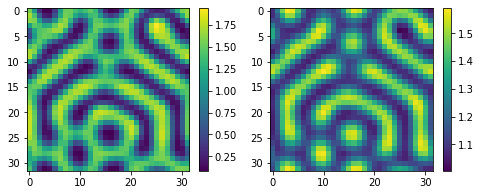

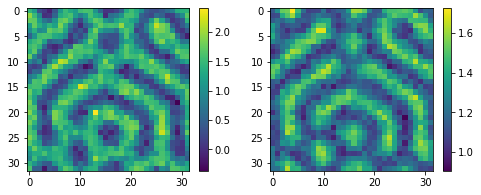

In [30]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obs_Y[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

In [94]:
model_params = {'training_data_size': T*32,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [95]:
layers = [3, 64, 64, 64, 64, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_lossKM = ASDM(dtype=tf.float64, D_a=.005, D_s=0.2, init_value=1.0)

modelKM = tu.TINN(pinnKM, 
                  pde_lossKM,                 
                  alpha = 0.5, 
                  print_precision=".8f")

In [96]:
results_KM = modelKM.train(epochs = 5000,
                          batch_size = 512,
                          X=obs_X,
                          Y=obs_Y,
                          X_pde=pde_X,
                          print_interval=10,
                          stop_threshold = 1e-5,
                          shuffle = True,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.34928414
total loss: 36.08644704, total regularisd loss: 36.08644704
obs u loss: 15.62783905, obs v loss: 8.43759332
pde u loss: 4.69201046, pde v loss: 7.32900421
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 0.86360 sigma_s: 0.89207 mu_a: 1.16931 rho_a: 0.84724 
rho_s: 1.04734 kappa_a: 1.03086 
Time taken: 20.67s

Start of epoch 10
Training observations acc over epoch: 0.15144277
total loss: 9.85081967, total regularisd loss: 34.78814960
obs u loss: 8.85756841, obs v loss: 0.83476840
pde u loss: 0.01748322, pde v loss: 0.14099964
lambda obs u: 3.91737000, lambda obs v: 0.08014923
lambda pde u: 0.00102983, lambda pde v: 0.00145094
sigma_a: 0.79715 sigma_s: 0.80411 mu_a: 1.26202 rho_a: 0.75045 
rho_s: 1.16681 kappa_a: 1.00076 
Time taken: 12.35s

Start of epoch 20
Training observations acc over epoch: 0.15183599
total loss: 9.89355316, total regularisd loss: 34.818


Start of epoch 190
Training observations acc over epoch: 0.15112044
total loss: 9.76814505, total regularisd loss: 35.02741920
obs u loss: 8.83699971, obs v loss: 0.83470784
pde u loss: 0.02218748, pde v loss: 0.07425003
lambda obs u: 3.94597745, lambda obs v: 0.05382650
lambda pde u: 0.00006349, lambda pde v: 0.00013256
sigma_a: 0.79700 sigma_s: 0.79771 mu_a: 1.26218 rho_a: 0.75027 
rho_s: 1.17544 kappa_a: 0.99590 
Time taken: 6.25s

Start of epoch 200
Training observations acc over epoch: 0.15134102
total loss: 9.79582490, total regularisd loss: 35.06390735
obs u loss: 8.84555951, obs v loss: 0.84026641
pde u loss: 0.02099687, pde v loss: 0.08900211
lambda obs u: 3.96401649, lambda obs v: 0.03579081
lambda pde u: 0.00004268, lambda pde v: 0.00015002
sigma_a: 0.79697 sigma_s: 0.79713 mu_a: 1.26222 rho_a: 0.75023 
rho_s: 1.17622 kappa_a: 0.99547 
Time taken: 6.21s

Start of epoch 210
Training observations acc over epoch: 0.15131095
total loss: 9.81227819, total regularisd loss: 35.070


Start of epoch 380
Training observations acc over epoch: 0.15103769
total loss: 9.70551266, total regularisd loss: 34.96307068
obs u loss: 8.83805066, obs v loss: 0.82836103
pde u loss: 0.02044810, pde v loss: 0.01865287
lambda obs u: 3.94714037, lambda obs v: 0.05277128
lambda pde u: 0.00005964, lambda pde v: 0.00002871
sigma_a: 0.79457 sigma_s: 0.78270 mu_a: 1.26484 rho_a: 0.74727 
rho_s: 1.19543 kappa_a: 0.98523 
Time taken: 6.25s

Start of epoch 390
Training observations acc over epoch: 0.15099640
total loss: 9.70607925, total regularisd loss: 34.98914677
obs u loss: 8.83490376, obs v loss: 0.82886655
pde u loss: 0.02195146, pde v loss: 0.02035749
lambda obs u: 3.95095838, lambda obs v: 0.04896784
lambda pde u: 0.00004951, lambda pde v: 0.00002427
sigma_a: 0.79439 sigma_s: 0.78213 mu_a: 1.26497 rho_a: 0.74710 
rho_s: 1.19619 kappa_a: 0.98483 
Time taken: 6.26s

Start of epoch 400
Training observations acc over epoch: 0.15206960
total loss: 9.80874854, total regularisd loss: 35.076


Start of epoch 570
Training observations acc over epoch: 0.14829156
total loss: 9.65222836, total regularisd loss: 34.21133511
obs u loss: 8.67564323, obs v loss: 0.81501689
pde u loss: 0.10269057, pde v loss: 0.05887768
lambda obs u: 3.93665052, lambda obs v: 0.06218238
lambda pde u: 0.00082899, lambda pde v: 0.00033812
sigma_a: 0.62643 sigma_s: 0.74522 mu_a: 1.14404 rho_a: 0.79429 
rho_s: 1.13311 kappa_a: 0.93490 
Time taken: 6.21s

Start of epoch 580
Training observations acc over epoch: 0.14821790
total loss: 9.65772537, total regularisd loss: 34.29183540
obs u loss: 8.67196823, obs v loss: 0.81397633
pde u loss: 0.10088508, pde v loss: 0.07089574
lambda obs u: 3.94471657, lambda obs v: 0.05410784
lambda pde u: 0.00083810, lambda pde v: 0.00033749
sigma_a: 0.57007 sigma_s: 0.74078 mu_a: 1.10047 rho_a: 0.80731 
rho_s: 1.10488 kappa_a: 0.90451 
Time taken: 6.22s

Start of epoch 590
Training observations acc over epoch: 0.14800501
total loss: 9.64220209, total regularisd loss: 34.238


Start of epoch 760
Training observations acc over epoch: 0.05222107
total loss: 3.35639445, total regularisd loss: 11.39463888
obs u loss: 2.97402134, obs v loss: 0.36812701
pde u loss: 0.00711201, pde v loss: 0.00713409
lambda obs u: 3.80355309, lambda obs v: 0.19083935
lambda pde u: 0.00182476, lambda pde v: 0.00378279
sigma_a: 0.00000 sigma_s: 0.02251 mu_a: 0.11643 rho_a: 0.21027 
rho_s: 0.04115 kappa_a: 1.02504 
Time taken: 6.26s

Start of epoch 770
Training observations acc over epoch: 0.04780285
total loss: 3.07100219, total regularisd loss: 10.34726246
obs u loss: 2.71074947, obs v loss: 0.34863312
pde u loss: 0.00467355, pde v loss: 0.00694605
lambda obs u: 3.80332224, lambda obs v: 0.19057316
lambda pde u: 0.00126430, lambda pde v: 0.00484031
sigma_a: 0.00000 sigma_s: 0.02256 mu_a: 0.09406 rho_a: 0.16964 
rho_s: 0.04014 kappa_a: 1.01278 
Time taken: 6.26s

Start of epoch 780
Training observations acc over epoch: 0.04343747
total loss: 2.79020678, total regularisd loss: 9.3607


Start of epoch 950
Training observations acc over epoch: 0.02549878
total loss: 1.63630234, total regularisd loss: 5.56599498
obs u loss: 1.45754607, obs v loss: 0.17437621
pde u loss: 0.00017719, pde v loss: 0.00420287
lambda obs u: 3.76922823, lambda obs v: 0.22475727
lambda pde u: 0.00002719, lambda pde v: 0.00598731
sigma_a: 0.00000 sigma_s: 0.02058 mu_a: 0.02048 rho_a: 0.03132 
rho_s: 0.03196 kappa_a: 0.70710 
Time taken: 6.28s

Start of epoch 960
Training observations acc over epoch: 0.02501984
total loss: 1.60556946, total regularisd loss: 5.47170678
obs u loss: 1.42948673, obs v loss: 0.17178303
pde u loss: 0.00015339, pde v loss: 0.00414631
lambda obs u: 3.78212295, lambda obs v: 0.21169139
lambda pde u: 0.00002304, lambda pde v: 0.00616262
sigma_a: 0.00000 sigma_s: 0.02075 mu_a: 0.01995 rho_a: 0.02958 
rho_s: 0.03049 kappa_a: 0.66753 
Time taken: 6.28s

Start of epoch 970
Training observations acc over epoch: 0.02570173
total loss: 1.64918597, total regularisd loss: 5.551582


Start of epoch 1140
Training observations acc over epoch: 0.02276728
total loss: 1.46096754, total regularisd loss: 4.90025870
obs u loss: 1.29130272, obs v loss: 0.16580312
pde u loss: 0.00004275, pde v loss: 0.00381895
lambda obs u: 3.78879972, lambda obs v: 0.20676253
lambda pde u: 0.00000340, lambda pde v: 0.00443435
sigma_a: 0.00103 sigma_s: 0.01846 mu_a: 0.01704 rho_a: 0.01702 
rho_s: 0.01945 kappa_a: 0.30480 
Time taken: 6.34s

Start of epoch 1150
Training observations acc over epoch: 0.02243965
total loss: 1.44000528, total regularisd loss: 4.84093433
obs u loss: 1.27786362, obs v loss: 0.15827395
pde u loss: 0.00004084, pde v loss: 0.00382687
lambda obs u: 3.76956291, lambda obs v: 0.22538635
lambda pde u: 0.00000345, lambda pde v: 0.00504729
sigma_a: 0.00099 sigma_s: 0.01813 mu_a: 0.01679 rho_a: 0.01675 
rho_s: 0.01968 kappa_a: 0.30295 
Time taken: 6.28s

Start of epoch 1160
Training observations acc over epoch: 0.02236811
total loss: 1.43540693, total regularisd loss: 4.866


Start of epoch 1330
Training observations acc over epoch: 0.02146751
total loss: 1.37783728, total regularisd loss: 4.64039829
obs u loss: 1.21886727, obs v loss: 0.15505336
pde u loss: 0.00003381, pde v loss: 0.00388285
lambda obs u: 3.78872913, lambda obs v: 0.20703430
lambda pde u: 0.00000287, lambda pde v: 0.00423370
sigma_a: 0.00045 sigma_s: 0.01829 mu_a: 0.01269 rho_a: 0.01291 
rho_s: 0.01888 kappa_a: 0.29544 
Time taken: 6.28s

Start of epoch 1340
Training observations acc over epoch: 0.02111857
total loss: 1.35549780, total regularisd loss: 4.57639428
obs u loss: 1.20188915, obs v loss: 0.14969947
pde u loss: 0.00003344, pde v loss: 0.00387574
lambda obs u: 3.74083936, lambda obs v: 0.25445141
lambda pde u: 0.00000348, lambda pde v: 0.00470576
sigma_a: 0.00042 sigma_s: 0.01838 mu_a: 0.01250 rho_a: 0.01273 
rho_s: 0.01897 kappa_a: 0.29494 
Time taken: 6.31s

Start of epoch 1350
Training observations acc over epoch: 0.02119744
total loss: 1.36057553, total regularisd loss: 4.527


Start of epoch 1520
Training observations acc over epoch: 0.02062620
total loss: 1.32416916, total regularisd loss: 4.43238320
obs u loss: 1.16796210, obs v loss: 0.15211437
pde u loss: 0.00003225, pde v loss: 0.00406044
lambda obs u: 3.78607427, lambda obs v: 0.20936118
lambda pde u: 0.00000281, lambda pde v: 0.00456174
sigma_a: 0.00000 sigma_s: 0.01770 mu_a: 0.00967 rho_a: 0.01023 
rho_s: 0.01925 kappa_a: 0.29969 
Time taken: 6.29s

Start of epoch 1530
Training observations acc over epoch: 0.02086534
total loss: 1.33951074, total regularisd loss: 4.49692907
obs u loss: 1.18363650, obs v loss: 0.15174515
pde u loss: 0.00003306, pde v loss: 0.00409603
lambda obs u: 3.77643311, lambda obs v: 0.21817511
lambda pde u: 0.00000333, lambda pde v: 0.00538846
sigma_a: 0.00000 sigma_s: 0.01808 mu_a: 0.00957 rho_a: 0.01015 
rho_s: 0.01935 kappa_a: 0.30035 
Time taken: 6.33s

Start of epoch 1540
Training observations acc over epoch: 0.02096685
total loss: 1.34601255, total regularisd loss: 4.509


Start of epoch 1710
Training observations acc over epoch: 0.02043083
total loss: 1.31192483, total regularisd loss: 4.41302627
obs u loss: 1.15677064, obs v loss: 0.15080268
pde u loss: 0.00003434, pde v loss: 0.00431717
lambda obs u: 3.77356858, lambda obs v: 0.22037490
lambda pde u: 0.00000345, lambda pde v: 0.00605308
sigma_a: 0.00000 sigma_s: 0.01843 mu_a: 0.00881 rho_a: 0.00940 
rho_s: 0.01929 kappa_a: 0.30285 
Time taken: 6.35s

Start of epoch 1720
Training observations acc over epoch: 0.02027899
total loss: 1.30223419, total regularisd loss: 4.36918313
obs u loss: 1.14825842, obs v loss: 0.14959682
pde u loss: 0.00003414, pde v loss: 0.00434481
lambda obs u: 3.76515298, lambda obs v: 0.22955032
lambda pde u: 0.00000360, lambda pde v: 0.00529310
sigma_a: 0.00000 sigma_s: 0.01785 mu_a: 0.00880 rho_a: 0.00940 
rho_s: 0.01942 kappa_a: 0.30373 
Time taken: 6.37s

Start of epoch 1730
Training observations acc over epoch: 0.02019970
total loss: 1.29719931, total regularisd loss: 4.326


Start of epoch 1900
Training observations acc over epoch: 0.01984921
total loss: 1.27500010, total regularisd loss: 4.26828572
obs u loss: 1.11859067, obs v loss: 0.15175919
pde u loss: 0.00003670, pde v loss: 0.00461354
lambda obs u: 3.78996271, lambda obs v: 0.20323757
lambda pde u: 0.00000333, lambda pde v: 0.00679639
sigma_a: 0.00000 sigma_s: 0.01826 mu_a: 0.00879 rho_a: 0.00933 
rho_s: 0.01914 kappa_a: 0.29684 
Time taken: 6.27s

Start of epoch 1910
Training observations acc over epoch: 0.01976988
total loss: 1.27004694, total regularisd loss: 4.23211891
obs u loss: 1.11542353, obs v loss: 0.14984890
pde u loss: 0.00003708, pde v loss: 0.00473742
lambda obs u: 3.75134899, lambda obs v: 0.24255202
lambda pde u: 0.00000403, lambda pde v: 0.00609496
sigma_a: 0.00000 sigma_s: 0.01868 mu_a: 0.00882 rho_a: 0.00931 
rho_s: 0.01893 kappa_a: 0.29554 
Time taken: 6.27s

Start of epoch 1920
Training observations acc over epoch: 0.01984620
total loss: 1.27500690, total regularisd loss: 4.239


Start of epoch 2090
Training observations acc over epoch: 0.01973003
total loss: 1.26790370, total regularisd loss: 4.23445629
obs u loss: 1.11082661, obs v loss: 0.15189496
pde u loss: 0.00004041, pde v loss: 0.00514172
lambda obs u: 3.75226865, lambda obs v: 0.24102933
lambda pde u: 0.00000476, lambda pde v: 0.00669726
sigma_a: 0.00000 sigma_s: 0.01823 mu_a: 0.00883 rho_a: 0.00922 
rho_s: 0.01855 kappa_a: 0.28766 
Time taken: 6.30s

Start of epoch 2100
Training observations acc over epoch: 0.01949489
total loss: 1.25283055, total regularisd loss: 4.14149695
obs u loss: 1.09347617, obs v loss: 0.15419647
pde u loss: 0.00004006, pde v loss: 0.00511785
lambda obs u: 3.76066485, lambda obs v: 0.23222305
lambda pde u: 0.00000470, lambda pde v: 0.00710741
sigma_a: 0.00000 sigma_s: 0.01799 mu_a: 0.00882 rho_a: 0.00923 
rho_s: 0.01840 kappa_a: 0.28692 
Time taken: 6.34s

Start of epoch 2110
Training observations acc over epoch: 0.01923583
total loss: 1.23629437, total regularisd loss: 4.092


Start of epoch 2280
Training observations acc over epoch: 0.01899672
total loss: 1.22144945, total regularisd loss: 4.00230452
obs u loss: 1.06241480, obs v loss: 0.15337499
pde u loss: 0.00004433, pde v loss: 0.00561534
lambda obs u: 3.74689959, lambda obs v: 0.24585077
lambda pde u: 0.00000588, lambda pde v: 0.00724376
sigma_a: 0.00000 sigma_s: 0.01850 mu_a: 0.00886 rho_a: 0.00916 
rho_s: 0.01870 kappa_a: 0.27919 
Time taken: 6.26s

Start of epoch 2290
Training observations acc over epoch: 0.01886637
total loss: 1.21306051, total regularisd loss: 4.01566508
obs u loss: 1.05618415, obs v loss: 0.15126365
pde u loss: 0.00004394, pde v loss: 0.00556877
lambda obs u: 3.76930458, lambda obs v: 0.22358073
lambda pde u: 0.00000496, lambda pde v: 0.00710973
sigma_a: 0.00000 sigma_s: 0.01795 mu_a: 0.00884 rho_a: 0.00919 
rho_s: 0.01891 kappa_a: 0.28017 
Time taken: 6.29s

Start of epoch 2300
Training observations acc over epoch: 0.01885941
total loss: 1.21266565, total regularisd loss: 3.999


Start of epoch 2470
Training observations acc over epoch: 0.01881125
total loss: 1.21014348, total regularisd loss: 3.97237724
obs u loss: 1.05018631, obs v loss: 0.15373352
pde u loss: 0.00004857, pde v loss: 0.00617507
lambda obs u: 3.76022033, lambda obs v: 0.23110106
lambda pde u: 0.00000615, lambda pde v: 0.00867245
sigma_a: 0.00000 sigma_s: 0.01790 mu_a: 0.00885 rho_a: 0.00910 
rho_s: 0.01866 kappa_a: 0.27292 
Time taken: 6.31s

Start of epoch 2480
Training observations acc over epoch: 0.01866039
total loss: 1.20041796, total regularisd loss: 3.93203653
obs u loss: 1.04147332, obs v loss: 0.15279197
pde u loss: 0.00004799, pde v loss: 0.00610467
lambda obs u: 3.76175790, lambda obs v: 0.22922622
lambda pde u: 0.00000666, lambda pde v: 0.00900922
sigma_a: 0.00000 sigma_s: 0.01811 mu_a: 0.00884 rho_a: 0.00910 
rho_s: 0.01881 kappa_a: 0.27310 
Time taken: 6.28s

Start of epoch 2490
Training observations acc over epoch: 0.01883526
total loss: 1.21166860, total regularisd loss: 3.978


Start of epoch 2660
Training observations acc over epoch: 0.01836509
total loss: 1.18210088, total regularisd loss: 3.88607427
obs u loss: 1.02298187, obs v loss: 0.15238408
pde u loss: 0.00005330, pde v loss: 0.00668164
lambda obs u: 3.74003303, lambda obs v: 0.25059064
lambda pde u: 0.00000653, lambda pde v: 0.00936980
sigma_a: 0.00000 sigma_s: 0.01910 mu_a: 0.00883 rho_a: 0.00906 
rho_s: 0.01870 kappa_a: 0.26780 
Time taken: 6.40s

Start of epoch 2670
Training observations acc over epoch: 0.01828997
total loss: 1.17731335, total regularisd loss: 3.87303201
obs u loss: 1.01792493, obs v loss: 0.15263327
pde u loss: 0.00005280, pde v loss: 0.00670235
lambda obs u: 3.75732898, lambda obs v: 0.23390169
lambda pde u: 0.00000710, lambda pde v: 0.00876224
sigma_a: 0.00000 sigma_s: 0.01882 mu_a: 0.00884 rho_a: 0.00903 
rho_s: 0.01827 kappa_a: 0.26850 
Time taken: 6.36s

Start of epoch 2680
Training observations acc over epoch: 0.01846845
total loss: 1.18874799, total regularisd loss: 3.884


Start of epoch 2850
Training observations acc over epoch: 0.01809522
total loss: 1.16553126, total regularisd loss: 3.78120535
obs u loss: 1.00510495, obs v loss: 0.15298900
pde u loss: 0.00005884, pde v loss: 0.00737847
lambda obs u: 3.72032717, lambda obs v: 0.26703899
lambda pde u: 0.00000951, lambda pde v: 0.01262433
sigma_a: 0.00000 sigma_s: 0.01839 mu_a: 0.00877 rho_a: 0.00890 
rho_s: 0.01843 kappa_a: 0.26029 
Time taken: 6.32s

Start of epoch 2860
Training observations acc over epoch: 0.01799859
total loss: 1.15930665, total regularisd loss: 3.73717028
obs u loss: 0.99852646, obs v loss: 0.15338343
pde u loss: 0.00005857, pde v loss: 0.00733819
lambda obs u: 3.71577081, lambda obs v: 0.27377510
lambda pde u: 0.00000805, lambda pde v: 0.01044605
sigma_a: 0.00000 sigma_s: 0.01881 mu_a: 0.00876 rho_a: 0.00892 
rho_s: 0.01880 kappa_a: 0.26096 
Time taken: 6.31s

Start of epoch 2870
Training observations acc over epoch: 0.01810869
total loss: 1.16650045, total regularisd loss: 3.790


Start of epoch 3040
Training observations acc over epoch: 0.01791420
total loss: 1.15464188, total regularisd loss: 3.72862206
obs u loss: 0.99068740, obs v loss: 0.15582128
pde u loss: 0.00006509, pde v loss: 0.00806810
lambda obs u: 3.72894265, lambda obs v: 0.25753958
lambda pde u: 0.00001024, lambda pde v: 0.01350752
sigma_a: 0.00001 sigma_s: 0.01868 mu_a: 0.00867 rho_a: 0.00884 
rho_s: 0.01900 kappa_a: 0.25469 
Time taken: 6.35s

Start of epoch 3050
Training observations acc over epoch: 0.01793142
total loss: 1.15590017, total regularisd loss: 3.70086837
obs u loss: 0.99153253, obs v loss: 0.15607834
pde u loss: 0.00006644, pde v loss: 0.00822287
lambda obs u: 3.70433281, lambda obs v: 0.27991282
lambda pde u: 0.00001057, lambda pde v: 0.01574380
sigma_a: 0.00000 sigma_s: 0.01934 mu_a: 0.00874 rho_a: 0.00876 
rho_s: 0.01865 kappa_a: 0.25295 
Time taken: 6.32s

Start of epoch 3060
Training observations acc over epoch: 0.01807461
total loss: 1.16509329, total regularisd loss: 3.719


Start of epoch 3230
Training observations acc over epoch: 0.01751415
total loss: 1.13004879, total regularisd loss: 3.63186761
obs u loss: 0.96690680, obs v loss: 0.15399891
pde u loss: 0.00007369, pde v loss: 0.00906938
lambda obs u: 3.67600559, lambda obs v: 0.30837271
lambda pde u: 0.00001362, lambda pde v: 0.01560808
sigma_a: 0.00000 sigma_s: 0.01875 mu_a: 0.00868 rho_a: 0.00869 
rho_s: 0.01907 kappa_a: 0.24790 
Time taken: 6.39s

Start of epoch 3240
Training observations acc over epoch: 0.01739436
total loss: 1.12240830, total regularisd loss: 3.56096210
obs u loss: 0.95832127, obs v loss: 0.15491770
pde u loss: 0.00007456, pde v loss: 0.00909478
lambda obs u: 3.68686763, lambda obs v: 0.30001814
lambda pde u: 0.00001196, lambda pde v: 0.01310227
sigma_a: 0.00000 sigma_s: 0.01871 mu_a: 0.00866 rho_a: 0.00869 
rho_s: 0.01899 kappa_a: 0.24875 
Time taken: 6.38s

Start of epoch 3250
Training observations acc over epoch: 0.01752092
total loss: 1.13050559, total regularisd loss: 3.610


Start of epoch 3420
Training observations acc over epoch: 0.01750865
total loss: 1.13059763, total regularisd loss: 3.61696160
obs u loss: 0.96324484, obs v loss: 0.15730850
pde u loss: 0.00008246, pde v loss: 0.00996184
lambda obs u: 3.70444520, lambda obs v: 0.27590852
lambda pde u: 0.00001809, lambda pde v: 0.01962819
sigma_a: 0.00000 sigma_s: 0.01844 mu_a: 0.00863 rho_a: 0.00868 
rho_s: 0.01873 kappa_a: 0.24746 
Time taken: 6.38s

Start of epoch 3430
Training observations acc over epoch: 0.01741576
total loss: 1.12479789, total regularisd loss: 3.59600088
obs u loss: 0.95743061, obs v loss: 0.15717807
pde u loss: 0.00008409, pde v loss: 0.01010511
lambda obs u: 3.71393260, lambda obs v: 0.26678642
lambda pde u: 0.00001733, lambda pde v: 0.01926365
sigma_a: 0.00000 sigma_s: 0.01849 mu_a: 0.00869 rho_a: 0.00864 
rho_s: 0.01896 kappa_a: 0.24760 
Time taken: 6.37s

Start of epoch 3440
Training observations acc over epoch: 0.01747302
total loss: 1.12848484, total regularisd loss: 3.609


Start of epoch 3610
Training observations acc over epoch: 0.01717675
total loss: 1.11026158, total regularisd loss: 3.52364165
obs u loss: 0.94115199, obs v loss: 0.15816032
pde u loss: 0.00009206, pde v loss: 0.01085721
lambda obs u: 3.70886624, lambda obs v: 0.27144860
lambda pde u: 0.00001824, lambda pde v: 0.01966692
sigma_a: 0.00000 sigma_s: 0.02049 mu_a: 0.00874 rho_a: 0.00872 
rho_s: 0.01874 kappa_a: 0.24810 
Time taken: 6.44s

Start of epoch 3620
Training observations acc over epoch: 0.01703932
total loss: 1.10163355, total regularisd loss: 3.47855203
obs u loss: 0.93488759, obs v loss: 0.15562853
pde u loss: 0.00009283, pde v loss: 0.01102460
lambda obs u: 3.66718679, lambda obs v: 0.31354755
lambda pde u: 0.00001780, lambda pde v: 0.01924786
sigma_a: 0.00000 sigma_s: 0.01915 mu_a: 0.00874 rho_a: 0.00874 
rho_s: 0.01991 kappa_a: 0.24776 
Time taken: 6.40s

Start of epoch 3630
Training observations acc over epoch: 0.01712947
total loss: 1.10745069, total regularisd loss: 3.496


Start of epoch 3800
Training observations acc over epoch: 0.01681101
total loss: 1.08786019, total regularisd loss: 3.43805604
obs u loss: 0.92015761, obs v loss: 0.15574678
pde u loss: 0.00010243, pde v loss: 0.01185336
lambda obs u: 3.68504789, lambda obs v: 0.29378519
lambda pde u: 0.00002049, lambda pde v: 0.02114644
sigma_a: 0.00000 sigma_s: 0.01962 mu_a: 0.00879 rho_a: 0.00878 
rho_s: 0.01940 kappa_a: 0.24854 
Time taken: 6.31s

Start of epoch 3810
Training observations acc over epoch: 0.01697513
total loss: 1.09849022, total regularisd loss: 3.45426081
obs u loss: 0.92832267, obs v loss: 0.15808541
pde u loss: 0.00010358, pde v loss: 0.01197857
lambda obs u: 3.68285424, lambda obs v: 0.29658321
lambda pde u: 0.00002085, lambda pde v: 0.02054170
sigma_a: 0.00000 sigma_s: 0.01994 mu_a: 0.00878 rho_a: 0.00878 
rho_s: 0.01946 kappa_a: 0.24803 
Time taken: 6.27s

Start of epoch 3820
Training observations acc over epoch: 0.01693456
total loss: 1.09585222, total regularisd loss: 3.465


Start of epoch 3990
Training observations acc over epoch: 0.01695378
total loss: 1.09815977, total regularisd loss: 3.40979233
obs u loss: 0.92298662, obs v loss: 0.16205555
pde u loss: 0.00011490, pde v loss: 0.01300270
lambda obs u: 3.68815726, lambda obs v: 0.28799880
lambda pde u: 0.00002090, lambda pde v: 0.02382305
sigma_a: 0.00000 sigma_s: 0.01910 mu_a: 0.00881 rho_a: 0.00870 
rho_s: 0.01899 kappa_a: 0.24371 
Time taken: 6.25s

Start of epoch 4000
Training observations acc over epoch: 0.01679383
total loss: 1.08824497, total regularisd loss: 3.45895433
obs u loss: 0.91799192, obs v loss: 0.15681285
pde u loss: 0.00011649, pde v loss: 0.01332371
lambda obs u: 3.68242257, lambda obs v: 0.29474725
lambda pde u: 0.00002233, lambda pde v: 0.02280786
sigma_a: 0.00000 sigma_s: 0.01933 mu_a: 0.00876 rho_a: 0.00872 
rho_s: 0.01943 kappa_a: 0.24401 
Time taken: 6.31s

Start of epoch 4010
Training observations acc over epoch: 0.01666056
total loss: 1.07957610, total regularisd loss: 3.382


Start of epoch 4180
Training observations acc over epoch: 0.01664688
total loss: 1.07972564, total regularisd loss: 3.36387837
obs u loss: 0.90775692, obs v loss: 0.15764324
pde u loss: 0.00012759, pde v loss: 0.01419789
lambda obs u: 3.64622441, lambda obs v: 0.32917634
lambda pde u: 0.00002858, lambda pde v: 0.02457067
sigma_a: 0.00000 sigma_s: 0.01948 mu_a: 0.00870 rho_a: 0.00875 
rho_s: 0.02005 kappa_a: 0.23991 
Time taken: 6.38s

Start of epoch 4190
Training observations acc over epoch: 0.01649196
total loss: 1.07008649, total regularisd loss: 3.35093061
obs u loss: 0.89798857, obs v loss: 0.15749674
pde u loss: 0.00012979, pde v loss: 0.01447140
lambda obs u: 3.66503900, lambda obs v: 0.30932713
lambda pde u: 0.00002611, lambda pde v: 0.02560776
sigma_a: 0.00000 sigma_s: 0.02168 mu_a: 0.00888 rho_a: 0.00857 
rho_s: 0.01918 kappa_a: 0.23847 
Time taken: 6.35s

Start of epoch 4200
Training observations acc over epoch: 0.01653473
total loss: 1.07290034, total regularisd loss: 3.340


Start of epoch 4370
Training observations acc over epoch: 0.01622341
total loss: 1.05423727, total regularisd loss: 3.24724100
obs u loss: 0.88339889, obs v loss: 0.15489954
pde u loss: 0.00014482, pde v loss: 0.01579402
lambda obs u: 3.60608440, lambda obs v: 0.36749686
lambda pde u: 0.00002992, lambda pde v: 0.02638882
sigma_a: 0.00000 sigma_s: 0.01977 mu_a: 0.00863 rho_a: 0.00853 
rho_s: 0.01942 kappa_a: 0.23088 
Time taken: 6.36s

Start of epoch 4380
Training observations acc over epoch: 0.01621089
total loss: 1.05306655, total regularisd loss: 3.26269297
obs u loss: 0.88132205, obs v loss: 0.15617515
pde u loss: 0.00014225, pde v loss: 0.01542710
lambda obs u: 3.64898387, lambda obs v: 0.32387493
lambda pde u: 0.00002875, lambda pde v: 0.02711245
sigma_a: 0.00000 sigma_s: 0.02019 mu_a: 0.00871 rho_a: 0.00843 
rho_s: 0.01829 kappa_a: 0.22892 
Time taken: 6.28s

Start of epoch 4390
Training observations acc over epoch: 0.01627870
total loss: 1.05795490, total regularisd loss: 3.277


Start of epoch 4560
Training observations acc over epoch: 0.01607098
total loss: 1.04552766, total regularisd loss: 3.22937306
obs u loss: 0.87178989, obs v loss: 0.15675296
pde u loss: 0.00015895, pde v loss: 0.01682586
lambda obs u: 3.64483764, lambda obs v: 0.32546668
lambda pde u: 0.00004191, lambda pde v: 0.02965376
sigma_a: 0.00000 sigma_s: 0.02059 mu_a: 0.00867 rho_a: 0.00843 
rho_s: 0.01964 kappa_a: 0.22407 
Time taken: 6.31s

Start of epoch 4570
Training observations acc over epoch: 0.01632909
total loss: 1.06228401, total regularisd loss: 3.27564404
obs u loss: 0.88729959, obs v loss: 0.15776213
pde u loss: 0.00016017, pde v loss: 0.01706212
lambda obs u: 3.64508972, lambda obs v: 0.32307738
lambda pde u: 0.00003666, lambda pde v: 0.03179624
sigma_a: 0.00000 sigma_s: 0.01987 mu_a: 0.00867 rho_a: 0.00837 
rho_s: 0.01968 kappa_a: 0.22530 
Time taken: 6.32s

Start of epoch 4580
Training observations acc over epoch: 0.01609908
total loss: 1.04762532, total regularisd loss: 3.212


Start of epoch 4750
Training observations acc over epoch: 0.01605823
total loss: 1.04626777, total regularisd loss: 3.20743657
obs u loss: 0.86987794, obs v loss: 0.15784870
pde u loss: 0.00017470, pde v loss: 0.01836643
lambda obs u: 3.61978077, lambda obs v: 0.34642525
lambda pde u: 0.00004615, lambda pde v: 0.03374783
sigma_a: 0.00000 sigma_s: 0.01965 mu_a: 0.00856 rho_a: 0.00835 
rho_s: 0.01989 kappa_a: 0.21661 
Time taken: 6.38s

Start of epoch 4760
Training observations acc over epoch: 0.01603217
total loss: 1.04477941, total regularisd loss: 3.20907673
obs u loss: 0.86682274, obs v loss: 0.15923598
pde u loss: 0.00017874, pde v loss: 0.01854195
lambda obs u: 3.65080050, lambda obs v: 0.31404836
lambda pde u: 0.00003726, lambda pde v: 0.03511388
sigma_a: 0.00000 sigma_s: 0.01953 mu_a: 0.00853 rho_a: 0.00833 
rho_s: 0.01923 kappa_a: 0.21675 
Time taken: 6.37s

Start of epoch 4770
Training observations acc over epoch: 0.01585140
total loss: 1.03298796, total regularisd loss: 3.189


Start of epoch 4940
Training observations acc over epoch: 0.01590032
total loss: 1.03836081, total regularisd loss: 3.17511269
obs u loss: 0.85911095, obs v loss: 0.15850921
pde u loss: 0.00019903, pde v loss: 0.02054162
lambda obs u: 3.63184159, lambda obs v: 0.32867442
lambda pde u: 0.00004317, lambda pde v: 0.03944082
sigma_a: 0.00000 sigma_s: 0.02086 mu_a: 0.00846 rho_a: 0.00835 
rho_s: 0.02049 kappa_a: 0.21061 
Time taken: 6.23s

Start of epoch 4950
Training observations acc over epoch: 0.01569206
total loss: 1.02465166, total regularisd loss: 3.11888256
obs u loss: 0.84589834, obs v loss: 0.15839370
pde u loss: 0.00019701, pde v loss: 0.02016261
lambda obs u: 3.64579330, lambda obs v: 0.31745469
lambda pde u: 0.00004208, lambda pde v: 0.03670993
sigma_a: 0.00000 sigma_s: 0.02086 mu_a: 0.00849 rho_a: 0.00824 
rho_s: 0.01889 kappa_a: 0.21285 
Time taken: 6.31s

Start of epoch 4960
Training observations acc over epoch: 0.01593480
total loss: 1.04003253, total regularisd loss: 3.190

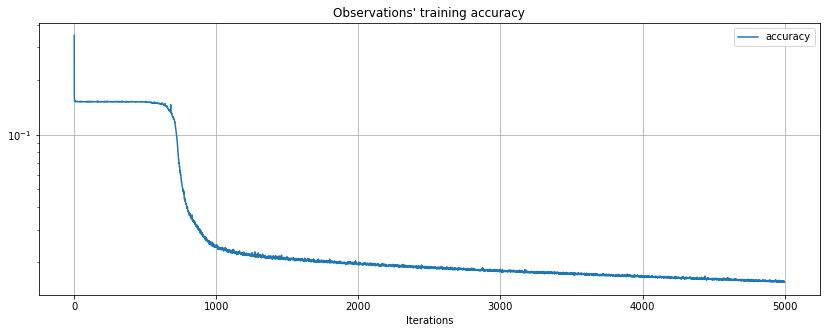

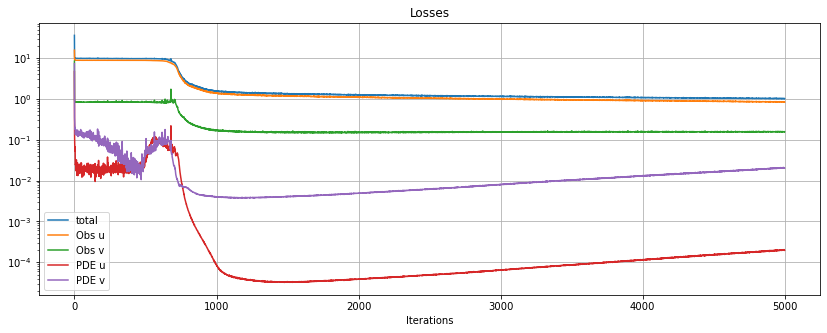

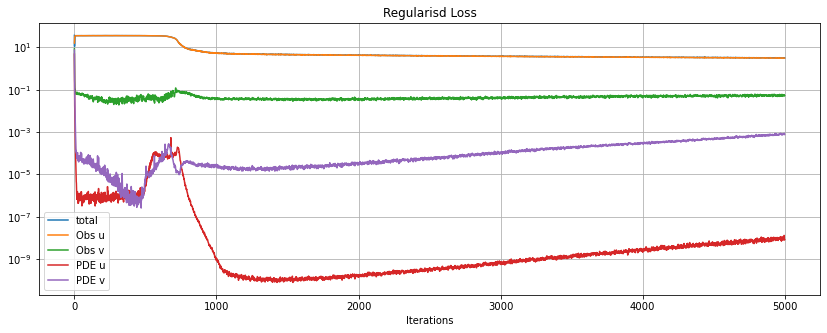

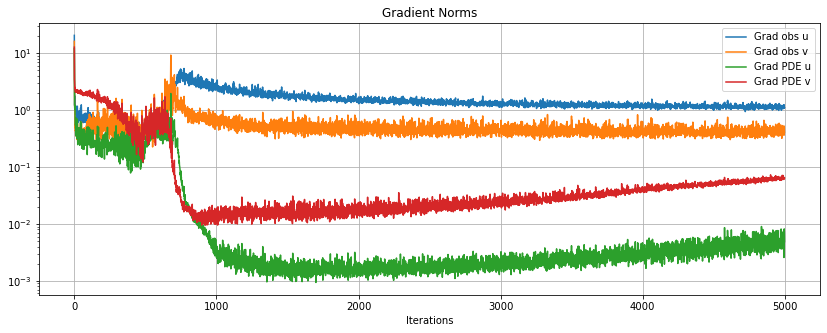

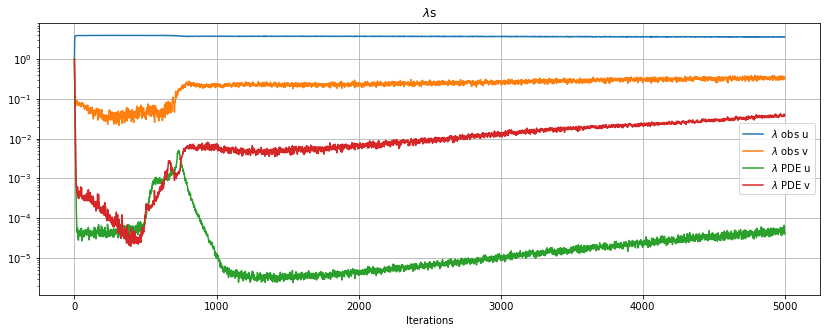

In [102]:
plot_result(merge_dict(results_KM))

In [104]:
import rdsolver

In [110]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (32, 32)
L = (50, 50)
t = t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = pde_lossKM.D_a.numpy()#0.01558*const1#0.005
D_s = pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
c0 = data[:, :, :, 0]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 512/512 [00:04<00:00, 113.07it/s]


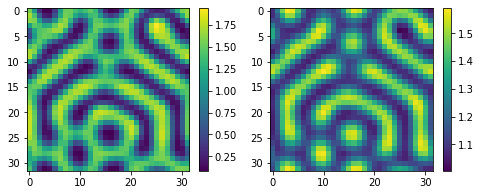

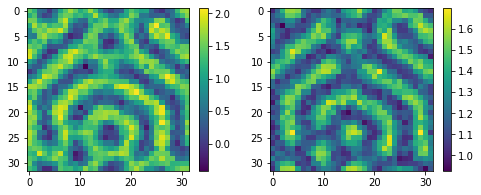

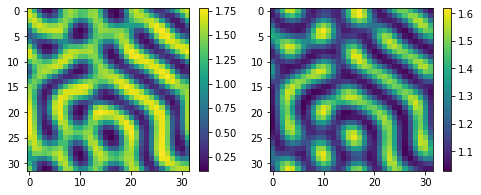

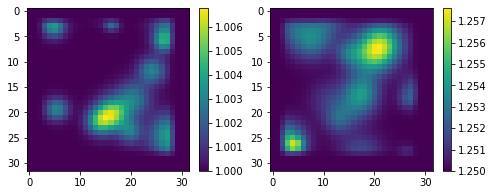

In [140]:
model_params_fig = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':False}
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

dataset_fig = create_dataset(data, t_star, N, T, L, **model_params_fig)
obs_Y_fig = dataset_fig['obs_output']

_ = plt.figure(figsize=(8,4))
plt.title("Original")
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("20% Noise")
plt.subplot(121)
plt.imshow(obs_Y_fig[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y_fig[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Initial condition")
plt.subplot(121)
plt.imshow(c[0, :,:,0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,0])
plt.colorbar(shrink=.75)
plt.show()

In [137]:
print(pde_lossKM.trainables_str())

sigma_a: 0.00000 sigma_s: 0.02089 mu_a: 0.00858 rho_a: 0.00819 
rho_s: 0.01939 kappa_a: 0.21088 


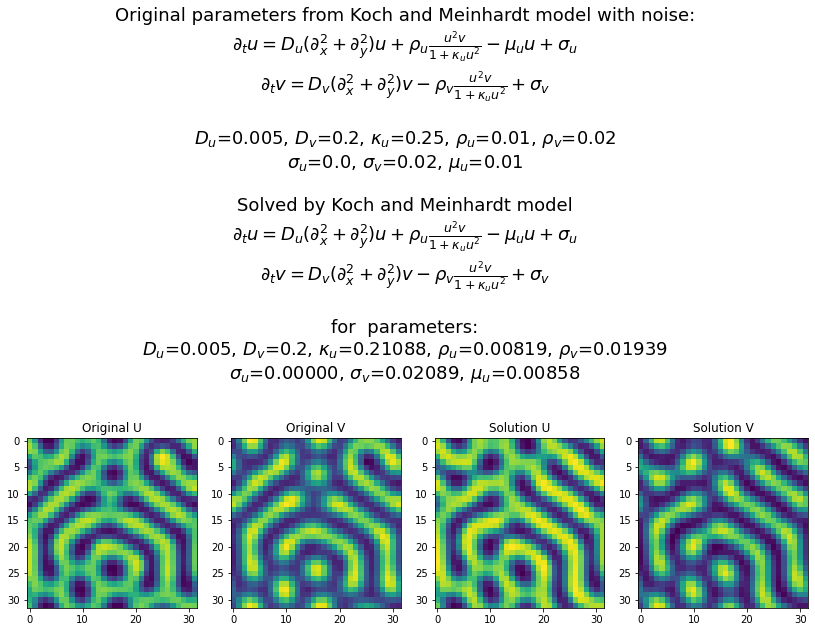

In [139]:
_ = plt.figure(figsize=(14,15))
# Direct solution
plt.suptitle(             "Original parameters from Koch and Meinhardt model with noise:\n"
             r"$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + \rho_u \frac{u^2 v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$"
             "\n"
             r"$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v - \rho_v \frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$"
             "\n"
             "\n"
             r"$D_u$=0.005, $D_v$=0.2, $\kappa_u$=0.25, $\rho_u$=0.01, $\rho_v$=0.02"
             "\n"
             r"$\sigma_u$=0.0, $\sigma_v$=0.02, $\mu_u$=0.01"
             "\n"
             "\n"
             "Solved by Koch and Meinhardt model\n"
             r"$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + \rho_u \frac{u^2 v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$"
             "\n"
             r"$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v - \rho_v \frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$"
             "\n"
             "\n"
             "for  parameters:\n"             
             r"$D_u$=0.005, $D_v$=0.2, $\kappa_u$=0.21088, $\rho_u$=0.00819, $\rho_v$=0.01939"
             "\n"
             r"$\sigma_u$=0.00000, $\sigma_v$=0.02089, $\mu_u$=0.00858"
             , fontsize=18)

plt.subplot(141)
plt.title("Original U")
plt.imshow(data[0, :,:,-1])
plt.subplot(142)
plt.title("Original V")
plt.imshow(data[1, :,:,-1])

plt.subplot(143)
plt.title("Solution U")
plt.imshow(c[0, :,:,-1])
plt.subplot(144)
plt.title("Solution V")
plt.imshow(c[1, :,:,-1])

plt.show()

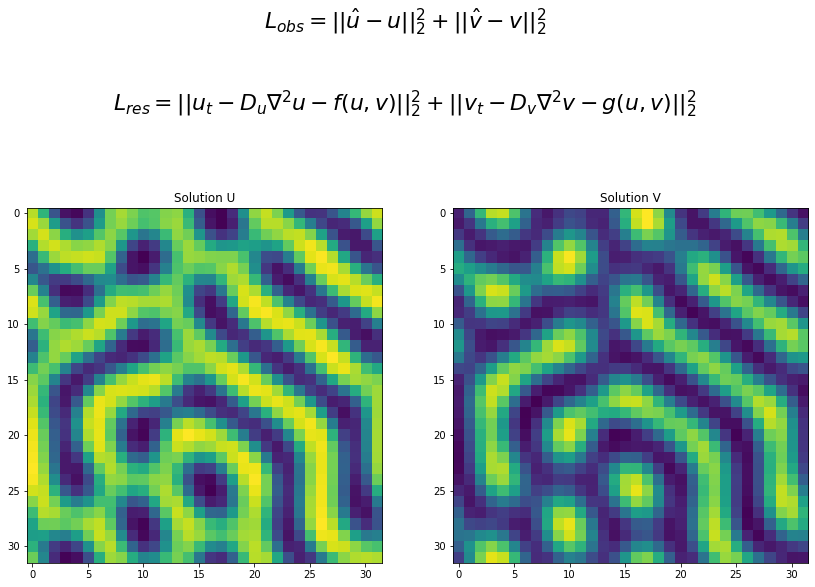

In [150]:
_ = plt.figure(figsize=(14,11))
# Direct solution
plt.suptitle(r"$L_{obs}=||\hat{u} - u||^2_2 + ||\hat{v} - v||^2_2$"
             "\n"
             "\n"
             "\n"
             r"$L_{res}=||u_t - D_u \nabla^2 u - f(u,v)||^2_2 + ||v_t - D_v \nabla^2 v - g(u,v)||^2_2$", fontsize=22)

plt.subplot(121)
plt.title("Solution U")
plt.imshow(c[0, :,:,-1])
plt.subplot(122)
plt.title("Solution V")
plt.imshow(c[1, :,:,-1])
plt.show()